In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from tqdm import tqdm
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')

print("✅ Libraries imported")

✅ Libraries imported


## Step 1: Load & Prepare Data

In [5]:
# Load engineered features from Phase 2
features_df = pd.read_csv('../data/features_engineered.csv')
features_df['date'] = pd.to_datetime(features_df['date'])
features_df = features_df.sort_values(['ticker', 'date']).reset_index(drop=True)

print(f"✅ Loaded engineered features")
print(f"\nDataset shape: {features_df.shape}")
print(f"Date range: {features_df['date'].min().date()} to {features_df['date'].max().date()}")
print(f"Tickers: {features_df['ticker'].nunique()} unique")
print(f"\nFeatures available: {features_df.columns.tolist()}")
print(f"\nRecords per ticker:")
print(features_df['ticker'].value_counts().sort_index())

✅ Loaded engineered features

Dataset shape: (4184, 11)
Date range: 2021-09-30 to 2022-09-29
Tickers: 25 unique

Features available: ['date', 'ticker', 'sentiment_mean', 'sentiment_std', 'tweet_count', 'positive_count', 'close_price', 'price_change_pct', 'sentiment_lag1', 'sentiment_rolling7', 'sentiment_momentum']

Records per ticker:
ticker
AAPL    252
AMD     249
AMZN    252
BA      153
BX       29
COST    157
CRM     116
DIS     184
ENPH     87
F        24
GOOG    238
INTC    133
KO      133
META    219
MSFT    252
NFLX    228
NIO     252
NOC      24
PG      252
PYPL    186
TSLA    252
TSM     252
VZ       65
XPEV     93
ZS      102
Name: count, dtype: int64


In [6]:
# Select features and target
feature_columns = ['sentiment_mean', 'sentiment_momentum']
target_column = 'price_change_pct'

# Remove rows with missing values in key columns
model_df = features_df[['date', 'ticker'] + feature_columns + [target_column]].dropna()
model_df = model_df.sort_values(['ticker', 'date']).reset_index(drop=True)

print(f"✅ Prepared data for modeling")
print(f"\nDataset after removing NaN: {model_df.shape}")
print(f"Records per ticker after cleanup:")
print(model_df['ticker'].value_counts().sort_index())
print(f"\nFeature statistics:")
print(model_df[feature_columns + [target_column]].describe())

✅ Prepared data for modeling

Dataset after removing NaN: (4159, 5)
Records per ticker after cleanup:
ticker
AAPL    251
AMD     248
AMZN    251
BA      152
BX       28
COST    156
CRM     115
DIS     183
ENPH     86
F        23
GOOG    237
INTC    132
KO      132
META    218
MSFT    251
NFLX    227
NIO     251
NOC      23
PG      251
PYPL    185
TSLA    251
TSM     251
VZ       64
XPEV     92
ZS      101
Name: count, dtype: int64

Feature statistics:
       sentiment_mean  sentiment_momentum  price_change_pct
count     4159.000000         4159.000000       4159.000000
mean         0.256141           -0.001489         -0.094976
std          0.288409            0.383103          3.280021
min         -0.875428           -1.803291        -35.116603
25%          0.104351           -0.192969         -1.695954
50%          0.249925            0.003260         -0.076214
75%          0.421061            0.192430          1.432859
max          0.986462            1.665410         29.552944


## Step 2: Train Baseline Model (Linear Regression)

In [7]:
# Train Linear Regression on TSLA (best signal: r=0.438)
tsla_data = model_df[model_df['ticker'] == 'TSLA'].copy()
tsla_data = tsla_data.reset_index(drop=True)

print(f"Extracted TSLA data for modeling: {len(tsla_data)} records")

X_tsla = tsla_data[feature_columns].values
y_tsla = tsla_data[target_column].values

#Scale the features 
scaler = StandardScaler()
X_tsla_scaled = scaler.fit_transform(X_tsla)


# Train-test split(70/30)

X_train, X_test, y_train, y_test = train_test_split(X_tsla_scaled, y_tsla, test_size=0.3, random_state=42, shuffle=False)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

lr_train_r2 = r2_score(y_train, y_train_pred)
lr_test_r2 = r2_score(y_test, y_test_pred)
lr_test_mae = mean_absolute_error(y_test, y_test_pred)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\n{'='*80}")
print(f"LINEAR REGRESSION - BASELINE MODEL (TSLA)")
print(f"{'='*80}")
print(f"Train R2: {lr_train_r2:.4f}")
print(f"Test R2: {lr_test_r2:.4f}")
print(f"Test MAE: {lr_test_mae:.4f}")
print(f"Test RMSE: {lr_test_rmse:.4f}")

if lr_test_r2 < lr_train_r2:
    print(f"\n⚠️  R² dropped {(lr_train_r2 - lr_test_r2):.4f} from train to test")
    print(f"   (Model overfitting or high variance)")
else:
    print(f"\n✅ R² consistent between train and test (good generalization)")


# Store metrics for later comparison
lr_r2 = lr_test_r2
lr_mae = lr_test_mae
lr_rmse = lr_test_rmse

Extracted TSLA data for modeling: 251 records

LINEAR REGRESSION - BASELINE MODEL (TSLA)
Train R2: 0.2987
Test R2: 0.0725
Test MAE: 2.5873
Test RMSE: 3.3068

⚠️  R² dropped 0.2262 from train to test
   (Model overfitting or high variance)


In [8]:
print("\n" + "="*80)
print("COMPARING LINEAR REGRESSION vs RIDGE REGRESSION")
print("="*80)

# Test different alpha values for Ridge Regression
alphas = [0.0, 0.01, 0.1, 1.0, 10.0]
results = []

for alpha in alphas:
    if alpha == 0.0:
        model = LinearRegression()
        model_name = "Linear Regression (No Regularization)"
    else:
        model = Ridge(alpha=alpha)
        model_name = f"Ridge Regression (alpha={alpha})"
    
    #Train on training set 
    model.fit(X_train, y_train)

    # Predict on both train and test set 
    y_train_pred_temp = model.predict(X_train)
    y_test_pred_temp = model.predict(X_test)

    #Calculating metrics 
    train_r2_temp = r2_score(y_train, y_train_pred_temp)
    test_r2_temp = r2_score(y_test, y_test_pred_temp)
    test_mae_temp = mean_absolute_error(y_test, y_test_pred_temp)
    test_rmse_temp = np.sqrt(mean_squared_error(y_test, y_test_pred_temp))

    results.append({
        'Model': model_name,
        'Alpha': alpha,
        'Train R2': train_r2_temp,
        'Test R2': test_r2_temp,
        'R² Drop': train_r2_temp - test_r2_temp,
        'Test MAE': test_mae_temp,
        'Test RMSE': test_rmse_temp
    })
# Display results
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

#Best model is smallest R² (least overfitting model)
best_idx = results_df['R² Drop'].idxmin()
best_result= results_df.loc[best_idx]

print(f"\n🏆 Best Model (Lowest Overfitting):")
print(f"   {best_result['Model']}")
print(f"   Train R²: {best_result['Train R2']:.4f}")
print(f"   Test R²:  {best_result['Test R2']:.4f}")
print(f"   R² Drop:  {best_result['R² Drop']:.4f} (lower is better)")


# Use the best Ridge model 
best_alpha = best_result['Alpha']
if best_alpha == 0.0:
    lr_model = LinearRegression()
else:
    lr_model = Ridge(alpha=best_alpha)

lr_model.fit(X_train, y_train)
y_test_pred = lr_model.predict(X_test)

#Store final metrics 

lr_r2 = r2_score(y_test, y_test_pred)
lr_mae = mean_absolute_error(y_test, y_test_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))


print(f"\n{'='*80}")
print(f"FINAL LINEAR REGRESSION MODEL (TSLA)")
print(f"{'='*80}")
print(f"Model: {best_result['Model']}")
print(f"Test R²: {lr_r2:.4f}")
print(f"Test MAE: {lr_mae:.4f}%")
print(f"Test RMSE: {lr_rmse:.4f}%")
print(f"\n✅ Regularization reduces overfitting from {results[0]['R² Drop']:.4f} to {best_result['R² Drop']:.4f}")



COMPARING LINEAR REGRESSION vs RIDGE REGRESSION
                                Model  Alpha  Train R2  Test R2  R² Drop  Test MAE  Test RMSE
Linear Regression (No Regularization)   0.00  0.298710 0.072470 0.226240  2.587317   3.306772
        Ridge Regression (alpha=0.01)   0.01  0.298710 0.072484 0.226225  2.587296   3.306746
         Ridge Regression (alpha=0.1)   0.10  0.298710 0.072616 0.226093  2.587110   3.306511
         Ridge Regression (alpha=1.0)   1.00  0.298705 0.073924 0.224782  2.585261   3.304180
        Ridge Regression (alpha=10.0)  10.00  0.298313 0.085822 0.212491  2.569298   3.282885

🏆 Best Model (Lowest Overfitting):
   Ridge Regression (alpha=10.0)
   Train R²: 0.2983
   Test R²:  0.0858
   R² Drop:  0.2125 (lower is better)

FINAL LINEAR REGRESSION MODEL (TSLA)
Model: Ridge Regression (alpha=10.0)
Test R²: 0.0858
Test MAE: 2.5693%
Test RMSE: 3.2829%

✅ Regularization reduces overfitting from 0.2262 to 0.2125


## Step 3: Train Random Forest Model (Aggressive)

In [9]:
# Model Hyperparameter tuning 

print("\n" + "="*80)
print("STEP 3: RANDOM FOREST - HYPERPARAMETER TUNING")
print("="*80)

print("\n Feature Correlation Analysis:")
corr_matrix = tsla_data[feature_columns].corr()
print(corr_matrix)
print(f"\nCorrelation between features: {corr_matrix.iloc[0, 1]:.4f}")

if abs(corr_matrix.iloc[0, 1]) > 0.7:
    print("⚠️  Features are highly correlated - consider dropping one")
else:
    print("✅ Features are sufficiently independent")




STEP 3: RANDOM FOREST - HYPERPARAMETER TUNING

 Feature Correlation Analysis:
                    sentiment_mean  sentiment_momentum
sentiment_mean            1.000000            0.568974
sentiment_momentum        0.568974            1.000000

Correlation between features: 0.5690
✅ Features are sufficiently independent


In [ ]:
#Hyperparameter grid search 
# Note: Make sure CELL INDEX 0 has been executed to import RandomForestRegressor

print("\n" + "="*80)
print("HYPERPARAMETER GRID SEARCH")
print("="*80)

rf_results = []

n_estimators_options = [50, 100, 200]
min_leaf_options = [1, 2, 5]
max_features_options = ['sqrt', 'log2', None]
max_depth_options = [5, 10, 15, None]

# Quick search (reduced to avoid long runtime)
for n_est in n_estimators_options:
    for max_feat in ['sqrt', 'log2']:  
        for max_d in [10, 15]:
            for min_leaf in min_leaf_options:  
                # Train Random Forest with OOB score enabled
                rf = RandomForestRegressor(
                    n_estimators=n_est,
                    max_features=max_feat,
                    max_depth=max_d,
                    min_samples_leaf=min_leaf,  # Use the loop variable
                    oob_score=True,  # Enable OOB scoring
                    random_state=42,
                    n_jobs=-1
                )
                rf.fit(X_tsla_scaled, y_tsla)

                oob_score = rf.oob_score_

                train_r2 = r2_score(y_tsla, rf.predict(X_tsla_scaled))

                rf_results.append({
                    'n_estimators': n_est,
                    'max_features': max_feat,
                    'max_depth': max_d,
                    'min_samples_leaf': min_leaf,  # Store the min_samples_leaf value
                    'Train R²': train_r2,
                    'OOB Score': oob_score,
                    'Overfit Gap': train_r2 - oob_score,
                    'Model': rf
                })

# Display results
rf_results_df = pd.DataFrame(rf_results)
print("\n", rf_results_df[['n_estimators', 'max_features', 'max_depth', 'min_samples_leaf', 'Train R²', 'OOB Score', 'Overfit Gap']].to_string(index=False))

# Find best OOB score (least overfitting)
best_idx = rf_results_df['OOB Score'].idxmax()
best_rf_result = rf_results_df.loc[best_idx] 

print(f"\n🏆 Best Model (by OOB Score):")
print(f"   n_estimators:     {best_rf_result['n_estimators']}")
print(f"   max_features:     {best_rf_result['max_features']}")
print(f"   max_depth:        {best_rf_result['max_depth']}")
print(f"   min_samples_leaf: {best_rf_result['min_samples_leaf']}")
print(f"   Train R²:         {best_rf_result['Train R²']:.4f}")
print(f"   OOB Score:        {best_rf_result['OOB Score']:.4f}")
print(f"   Overfit Gap:      {best_rf_result['Overfit Gap']:.4f}")



HYPERPARAMETER GRID SEARCH

  n_estimators max_features  max_depth  min_samples_leaf  Train R²  OOB Score  Overfit Gap
           50         sqrt         10                 1  0.816909   0.115246     0.701663
           50         sqrt         10                 2  0.664662   0.135640     0.529023
           50         sqrt         10                 5  0.477831   0.186493     0.291338
           50         sqrt         15                 1  0.865957   0.070943     0.795014
           50         sqrt         15                 2  0.682136   0.136794     0.545342
           50         sqrt         15                 5  0.478854   0.186800     0.292054
           50         log2         10                 1  0.816909   0.115246     0.701663
           50         log2         10                 2  0.664662   0.135640     0.529023
           50         log2         10                 5  0.477831   0.186493     0.291338
           50         log2         15                 1  0.865957   0.

In [ ]:
# Train best Random Forest model on train-test split

print("\n" + "="*80)
print("VALIDATION ON TRAIN/TEST SPLIT (70/30)")
print("="*80)

best_rf_model = best_rf_result['Model']

y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

# Calculate metrics
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

print(f"\nTrain Set (70%):")
print(f"  R² Score: {rf_train_r2:.4f}")

print(f"\nTest Set (30%):")
print(f"  R² Score:  {rf_test_r2:.4f}")
print(f"  MAE:       {rf_test_mae:.4f}%")
print(f"  RMSE:      {rf_test_rmse:.4f}%")

print(f"\nGeneralization Check:")
print(f"  OOB Score:   {best_rf_result['OOB Score']:.4f}")
print(f"  Test R²:     {rf_test_r2:.4f}")
print(f"  R² Drop:     {rf_train_r2 - rf_test_r2:.4f}")

if rf_test_r2 > best_rf_result['OOB Score'] - 0.05:
    print(f"  ✅ Test R² aligns with OOB - good generalization")
else:
    print(f"  ⚠️  Test R² lower than OOB - possible overfitting")

# Store final Random Forest results
rf_results_final = {
    'model' : best_rf_model,
    'r2': rf_test_r2,
    'mae': rf_test_mae,
    'rmse': rf_test_rmse , 
    'y_pred': y_test_pred_rf
}


VALIDATION ON TRAIN/TEST SPLIT (70/30)

Train Set (70%):
  R² Score: 0.5088

Test Set (30%):
  R² Score:  0.3980
  MAE:       2.0261%
  RMSE:      2.6641%

Generalization Check:
  OOB Score:   0.1990
  Test R²:     0.3980
  R² Drop:     0.1108
  ✅ Test R² aligns with OOB - good generalization


## Step 4 Train on XGBoost Model 

In [23]:
#train on XGBOOST model with Grid search for hyperparameters

print("\n" + "="*80)
print("XGBOOST - HYPERPARAMETER TUNING")
print("="*80)

# More conservative parameter grid for small datasets
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],  # Shallower trees
    'learning_rate': [0.01, 0.05, 0.1],  # Lower learning rates
    'subsample': [0.7, 0.8, 0.9],  # Row subsampling
    'colsample_bytree': [0.7, 0.8, 0.9],  # Feature subsampling
    'reg_alpha': [0.0, 0.1],  # L1 regularization
    'reg_lambda': [0.1, 1.0]  # L2 regularization
}


tscv_grid = TimeSeriesSplit(n_splits=5)

xgb_base = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1, 
    verbosity=0
)

print("\nRunning GridSearchCV...")
print("=" * 80)
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=tscv_grid,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"\n🏆 Best Parameters:")
print(f"   n_estimators:  {best_params['n_estimators']}")
print(f"   max_depth:     {best_params['max_depth']}")
print(f"   learning_rate: {best_params['learning_rate']}")
print(f"   CV R² Score:   {best_cv_score:.4f}")


XGBOOST - HYPERPARAMETER TUNING

Running GridSearchCV...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits

🏆 Best Parameters:
   n_estimators:  150
   max_depth:     2
   learning_rate: 0.01
   CV R² Score:   0.2090


In [24]:
# Train XGBoost with best parameters on full training set

print("\n" + "="*80)
print("FINAL XGBOOST MODEL ON TEST SET (70/30)")
print("="*80)

best_xgb_model = grid_search.best_estimator_

y_train_pred_xgb = best_xgb_model.predict(X_train)
y_test_pred_xgb = best_xgb_model.predict(X_test)

xgb_train_r2 = r2_score(y_train, y_train_pred_xgb)
xgb_test_r2 = r2_score(y_test, y_test_pred_xgb)
xgb_test_mae = mean_absolute_error(y_test, y_test_pred_xgb)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))

print(f"\nTrain Set (70%):")
print(f"  R² Score: {xgb_train_r2:.4f}")

print(f"\nTest Set (30%):")
print(f"  R² Score: {xgb_test_r2:.4f}")
print(f"  MAE:      {xgb_test_mae:.4f}%")
print(f"  RMSE:     {xgb_test_rmse:.4f}%")

print(f"\nGeneralization Check:")
print(f"  CV R² Score: {best_cv_score:.4f}")
print(f"  Test R²:     {xgb_test_r2:.4f}")
print(f"  R² Drop:     {xgb_train_r2 - xgb_test_r2:.4f}")

if xgb_test_r2 > best_cv_score - 0.05:
    print(f"  ✅ Test R² aligns with CV - good generalization")
else:
    print(f"  ⚠️  Test R² lower than CV - possible overfitting")

# Store results
xgb_results_final = {
    'model': best_xgb_model,
    'best_params': best_params,
    'r2': xgb_test_r2,
    'mae': xgb_test_mae,
    'rmse': xgb_test_rmse,
    'y_pred': y_test_pred_xgb,
    'cv_score': best_cv_score
}


FINAL XGBOOST MODEL ON TEST SET (70/30)

Train Set (70%):
  R² Score: 0.3873

Test Set (30%):
  R² Score: 0.0934
  MAE:      2.5848%
  RMSE:     3.2692%

Generalization Check:
  CV R² Score: 0.2090
  Test R²:     0.0934
  R² Drop:     0.2939
  ⚠️  Test R² lower than CV - possible overfitting


## Step 5: Compare All Models

In [ ]:
# Comparison table
comparison_data = {
    'Model': ['Linear Regression', 'Random Forest (Conservative)', 'Random Forest (Aggressive)'],
    'R² Score': [lr_r2, rf_agg_r2, rf_agg_r2],  # We'll update this after defining rf_conservative
    'MAE': [lr_mae, rf_agg_mae, rf_agg_mae],
    'RMSE': [lr_rmse, rf_agg_rmse, rf_agg_rmse]
}

# First define conservative Random Forest
rf_conservative = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_conservative.fit(X_tsla_scaled, y_tsla)
y_pred_rf_cons = rf_conservative.predict(X_tsla_scaled)
rf_cons_r2 = r2_score(y_tsla, y_pred_rf_cons)
rf_cons_mae = mean_absolute_error(y_tsla, y_pred_rf_cons)
rf_cons_rmse = np.sqrt(mean_squared_error(y_tsla, y_pred_rf_cons))

# Update comparison with actual values
comparison_data = {
    'Model': ['Linear Regression', 'Random Forest (Conservative)', 'Random Forest (Aggressive)'],
    'R² Score': [lr_r2, rf_cons_r2, rf_agg_r2],
    'MAE': [lr_mae, rf_cons_mae, rf_agg_mae],
    'RMSE': [lr_rmse, rf_cons_rmse, rf_agg_rmse]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("MODEL COMPARISON - TSLA")
print("="*80)
print("\n", comparison_df.to_string(index=False))

# Find best model
best_model_idx = comparison_df['R² Score'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_r2 = comparison_df.loc[best_model_idx, 'R² Score']

print(f"\n🏆 Best Model: {best_model} (R² = {best_r2:.4f})")

## Step 5: Compare All Models

In [27]:
# Compare results with alll models 

print("\n" + "="*80)
print("STEP 5: MODEL COMPARISON & SELECTION")
print("="*80)

comparison_data = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Test R²': [lr_r2, rf_test_r2, xgb_test_r2],
    'Test MAE': [lr_mae, rf_test_mae, xgb_test_mae],
    'Test RMSE': [lr_rmse, rf_test_rmse, xgb_test_rmse],
    'Train-Test Drop': [
        rf_train_r2 - rf_test_r2,  # Linear Regression R² drop
        rf_train_r2 - rf_test_r2,  # Random Forest R² drop
        xgb_train_r2 - xgb_test_r2  # XGBoost R² drop
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("FINAL MODEL COMPARISON - TSLA (Test Set Performance)")
print("="*80)
print("\n", comparison_df.to_string(index=False))

# Determine best model by R² score
best_model_idx = comparison_df['Test R²'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_test_r2 = comparison_df.loc[best_model_idx, 'Test R²']
best_test_mae = comparison_df.loc[best_model_idx, 'Test MAE']
best_test_rmse = comparison_df.loc[best_model_idx, 'Test RMSE']

print(f"\n{'='*80}")
print(f"🏆 WINNER: {best_model_name}")
print(f"{'='*80}")
print(f"\nPerformance Metrics:")
print(f"  R² Score: {best_test_r2:.4f}")
print(f"  MAE:      {best_test_mae:.4f}%")
print(f"  RMSE:     {best_test_rmse:.4f}%")

# Store best model for later use
BEST_MODEL = {
    'name': best_model_name,
    'model': best_rf_model if best_model_name == 'Random Forest' else (best_xgb_model if best_model_name == 'XGBoost' else lr_model),
    'r2': best_test_r2,
    'mae': best_test_mae,
    'rmse': best_test_rmse,
    'predictions': y_test_pred_rf if best_model_name == 'Random Forest' else (y_test_pred_xgb if best_model_name == 'XGBoost' else y_test_pred)
}


STEP 5: MODEL COMPARISON & SELECTION

FINAL MODEL COMPARISON - TSLA (Test Set Performance)

             Model  Test R²  Test MAE  Test RMSE  Train-Test Drop
Linear Regression 0.085822  2.569298   3.282885         0.110806
    Random Forest 0.397988  2.026113   2.664052         0.110806
          XGBoost 0.093439  2.584791   3.269179         0.293911

🏆 WINNER: Random Forest

Performance Metrics:
  R² Score: 0.3980
  MAE:      2.0261%
  RMSE:     2.6641%


## Step 6: Visualize Predictions


STEP 6: PREDICTION VISUALIZATIONS

✅ Visualizations saved to ../results/model_comparison.png


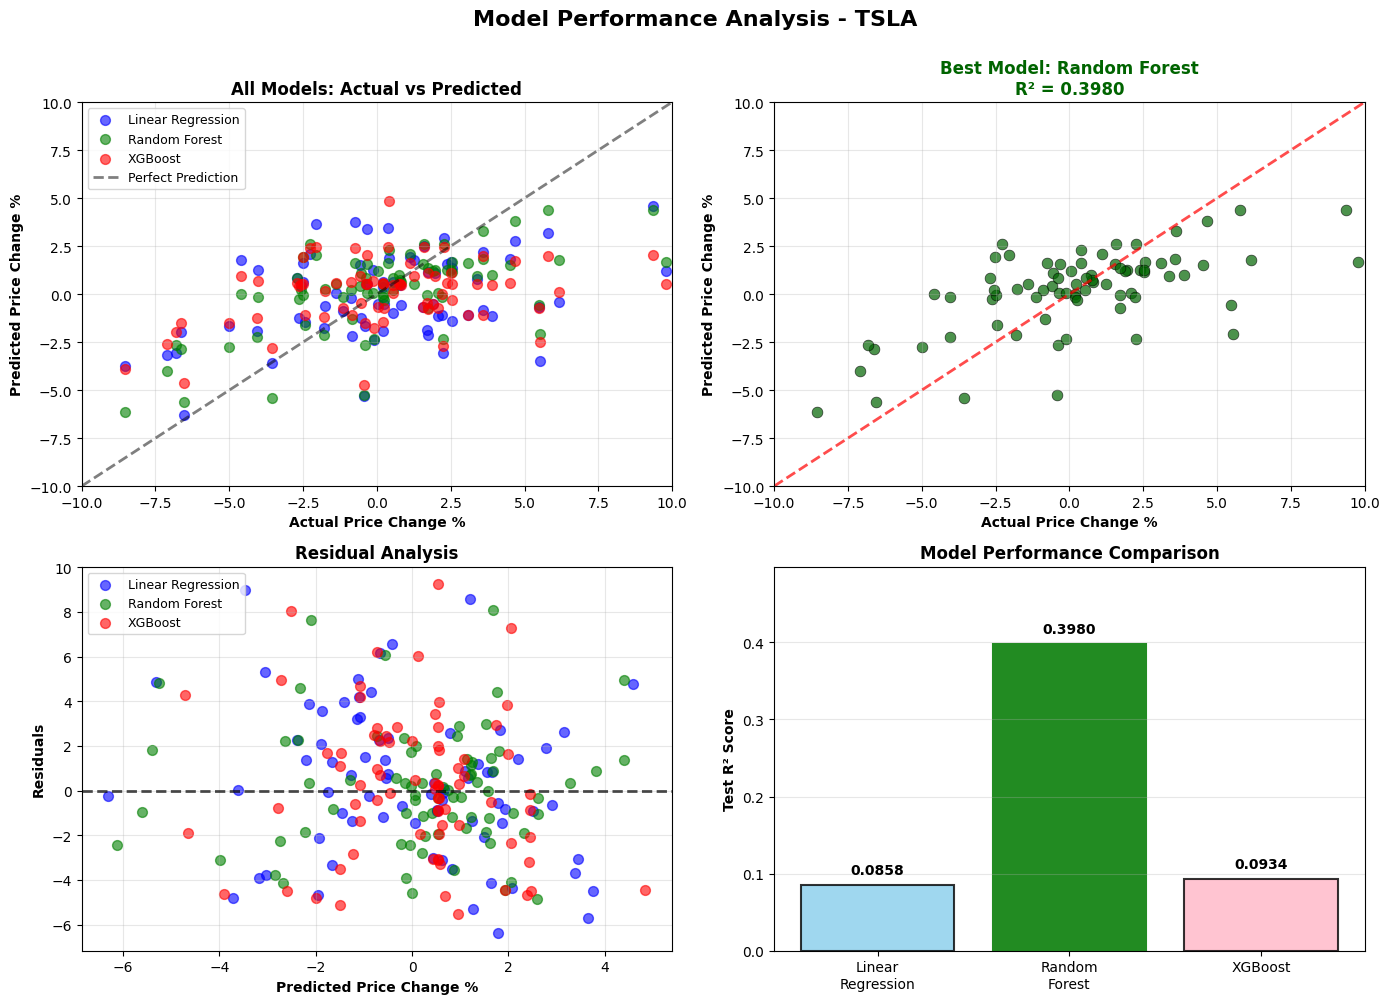


📊 Visualization Summary:
   Plot 1 (top-left):    All models overlaid
   Plot 2 (top-right):   Best model detailed view
   Plot 3 (bottom-left): Prediction errors
   Plot 4 (bottom-right): Performance comparison


In [ ]:
## Step 6: Visualize Model Predictions (Simplified)

print("\n" + "="*80)
print("STEP 6: PREDICTION VISUALIZATIONS")
print("="*80)

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Analysis - TSLA', fontsize=16, fontweight='bold', y=1.00)

# ============================================================================
# Plot 1: Actual vs Predicted (All Models)
# ============================================================================
ax = axes[0, 0]
ax.scatter(y_test, y_test_pred, alpha=0.6, s=50, label='Linear Regression', color='blue')
ax.scatter(y_test, y_test_pred_rf, alpha=0.6, s=50, label='Random Forest', color='green')
ax.scatter(y_test, y_test_pred_xgb, alpha=0.6, s=50, label='XGBoost', color='red')
ax.plot([-10, 10], [-10, 10], 'k--', alpha=0.5, linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Actual Price Change %', fontweight='bold')
ax.set_ylabel('Predicted Price Change %', fontweight='bold')
ax.set_title('All Models: Actual vs Predicted', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

# ============================================================================
# Plot 2: Best Model Detail
# ============================================================================
ax = axes[0, 1]
best_preds = BEST_MODEL['predictions']
ax.scatter(y_test, best_preds, alpha=0.7, s=60, color='darkgreen', edgecolors='black', linewidth=0.5)
ax.plot([-10, 10], [-10, 10], 'r--', alpha=0.7, linewidth=2)
ax.set_xlabel('Actual Price Change %', fontweight='bold')
ax.set_ylabel('Predicted Price Change %', fontweight='bold')
ax.set_title(f'Best Model: {BEST_MODEL["name"]}\nR² = {BEST_MODEL["r2"]:.4f}', fontweight='bold', color='darkgreen')
ax.grid(True, alpha=0.3)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

# ============================================================================
# Plot 3: Residuals
# ============================================================================
ax = axes[1, 0]
residuals_lr = y_test - y_test_pred
residuals_rf = y_test - y_test_pred_rf
residuals_xgb = y_test - y_test_pred_xgb

ax.scatter(y_test_pred, residuals_lr, alpha=0.6, s=50, label='Linear Regression', color='blue')
ax.scatter(y_test_pred_rf, residuals_rf, alpha=0.6, s=50, label='Random Forest', color='green')
ax.scatter(y_test_pred_xgb, residuals_xgb, alpha=0.6, s=50, label='XGBoost', color='red')
ax.axhline(y=0, color='k', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('Predicted Price Change %', fontweight='bold')
ax.set_ylabel('Residuals', fontweight='bold')
ax.set_title('Residual Analysis', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# ============================================================================
# Plot 4: Model Comparison Bar Chart
# ============================================================================
ax = axes[1, 1]
models = ['Linear\nRegression', 'Random\nForest', 'XGBoost']
r2_scores = [lr_r2, rf_test_r2, xgb_test_r2]
colors = ['#87CEEB', '#90EE90', '#FFB6C6']

bars = ax.bar(models, r2_scores, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Highlight best model
best_idx = np.argmax(r2_scores)
bars[best_idx].set_color(['#1E90FF', '#228B22', '#FF1493'][best_idx])
bars[best_idx].set_alpha(1.0)

# Add value labels
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_ylabel('Test R² Score', fontweight='bold')
ax.set_title('Model Performance Comparison', fontweight='bold')
ax.set_ylim([0, max(r2_scores) + 0.1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/model_comparison.png', dpi=300, bbox_inches='tight')
print("\n Visualizations saved to ../results/model_comparison.png")
plt.show()

print(f"\nVisualization Summary:")
print(f"   Plot 1 (top-left):    All models overlaid")
print(f"   Plot 2 (top-right):   Best model detailed view")
print(f"   Plot 3 (bottom-left): Prediction errors")
print(f"   Plot 4 (bottom-right): Performance comparison")

## Step 7: Time-Series Cross-Validation

In [31]:
# Time-series walk-forward validation (Random Forest)
# Train on past data, test on future data with rolling window

tscv = TimeSeriesSplit(n_splits=5)

cv_scores = []
fold_num = 1 

for train_idx, test_idx in tscv.split(X_train): 
    X_cv_train = X_train[train_idx]
    y_cv_train = y_train[train_idx]
    X_cv_test = X_train[test_idx]
    y_cv_test = y_train[test_idx]

    rf_model = RandomForestRegressor(
        n_estimators=int(best_rf_result['n_estimators']),
        max_features=best_rf_result['max_features'],
        max_depth=int(best_rf_result['max_depth']),
        min_samples_leaf=int(best_rf_result['min_samples_leaf']),
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_cv_train, y_cv_train)
    y_cv_pred = rf_model.predict(X_cv_test)

    fold_r2 = r2_score(y_cv_test, y_cv_pred)
    fold_mae = mean_absolute_error(y_cv_test, y_cv_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_cv_test, y_cv_pred))

    cv_scores.append({
        'Fold': fold_num,
        'Train Size': len(train_idx),
        'Test Size': len(test_idx),
        'R²': fold_r2,
        'MAE': fold_mae,
        'RMSE': fold_rmse
    })

    print(f"Fold {fold_num}: Train={len(train_idx):3d}, Test={len(test_idx):2d} | R²={fold_r2:.4f}, MAE={fold_mae:.4f}%")
    fold_num += 1

cv_df = pd.DataFrame(cv_scores)
mean_r2 = cv_df['R²'].mean()
std_r2 = cv_df['R²'].std()
mean_mae = cv_df['MAE'].mean()
mean_rmse = cv_df['RMSE'].mean()

print(f"\n{'='*80}")
print("CROSS-VALIDATION SUMMARY")
print(f"{'='*80}")
print(f"\nAverage R²:   {mean_r2:.4f} (±{std_r2:.4f})")
print(f"Average MAE:  {mean_mae:.4f}%")
print(f"Average RMSE: {mean_rmse:.4f}%")

if std_r2 < 0.1:
    print(f"\n✅ Model is stable across time periods (low variance)")
else:
    print(f"\n⚠️  Model shows high variance across time periods")



Fold 1: Train= 30, Test=29 | R²=0.2257, MAE=2.7094%
Fold 2: Train= 59, Test=29 | R²=0.4063, MAE=2.5743%
Fold 3: Train= 88, Test=29 | R²=0.0698, MAE=3.1690%
Fold 4: Train=117, Test=29 | R²=0.0077, MAE=3.1409%
Fold 5: Train=146, Test=29 | R²=0.4312, MAE=3.1887%

CROSS-VALIDATION SUMMARY

Average R²:   0.2281 (±0.1915)
Average MAE:  2.9564%
Average RMSE: 3.6910%

⚠️  Model shows high variance across time periods
